In [1]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

#### Q1: Read the data for January. How many columns are there?

In [2]:
df = pd.read_parquet('./data/yellow_tripdata_2023-01.parquet')

In [3]:
len(df.columns)

19

#### Q2: What's the standard deviation of the trips duration in January?

In [4]:
df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
df.duration.describe()

count    3.066766e+06
mean     1.566900e+01
std      4.259435e+01
min     -2.920000e+01
25%      7.116667e+00
50%      1.151667e+01
75%      1.830000e+01
max      1.002918e+04
Name: duration, dtype: float64

#### Q3: What fraction of the records left after you dropped the outliers?

We need to check the distribution of the duration variable.
There are some outliers. 
Let's remove them and keep only the records where the duration was between 1 and 60 minutes (inclusive).

/tmp/ipykernel_1775/3426635498.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.duration)
/home/mlops_zoomcamp_gcp/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='duration', ylabel='Density'>

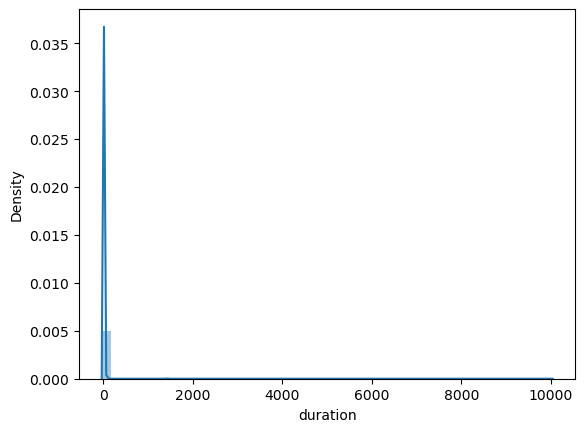

In [5]:
sns.distplot(df.duration)

In [6]:
df_no_outliers = df[(df.duration >= 1) & (df.duration <= 60)]

print(f'Percentage of data without duration outliers: {(len(df_no_outliers) / len(df)) * 100}%')

Percentage of data without duration outliers: 98.1220282212598%


In [7]:
df = df_no_outliers

#### Q4. One-hot encodingLet's apply one-hot encoding to the pickup and dropoff location IDs. We'll use only these two features for our model.

Turn the dataframe into a list of dictionaries (remember to re-cast the ids to strings - otherwise it will label encode them)
Fit a dictionary vectorizer
Get a feature matrix from it
What's the dimensionality of this matrix (number of columns)?


In [8]:
categorical = ['PULocationID', 'DOLocationID']
# numerical = ['trip_distance']

df.loc[:, categorical] = df[categorical].astype(str)

In [9]:
df.dtypes

VendorID                          int64
tpep_pickup_datetime     datetime64[us]
tpep_dropoff_datetime    datetime64[us]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                     object
DOLocationID                     object
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
airport_fee                     float64
duration                        float64
dtype: object

In [10]:
train_dicts = df[categorical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [11]:
X_train.get_shape()

(3009173, 515)

### Q5. Now let's use the feature matrix from the previous step to train a model.

Train a plain linear regression model with default parameters
Calculate the RMSE of the model on the training data
What's the RMSE on train?

In [12]:
target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

7.649262109734842

/home/mlops_zoomcamp_gcp/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/mlops_zoomcamp_gcp/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


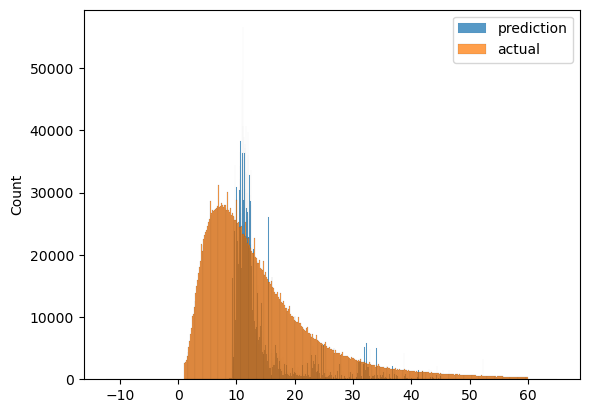

In [13]:
sns.histplot(y_pred, label='prediction')
sns.histplot(y_train, label='actual')

plt.legend()

Not exactly the best model in town.
Although technically it is since he's the only one here

### Q6. Evaluating the model
Now let's apply this model to the validation dataset (February 2023).

What's the RMSE on validation?

In [14]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)

    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df.loc[:, categorical] = df[categorical].astype(str)
    
    return df

In [15]:
df_train = read_dataframe('./data/yellow_tripdata_2023-01.parquet')
df_val = read_dataframe('./data/yellow_tripdata_2023-02.parquet')

In [16]:
categorical = ['PULocationID', 'DOLocationID']

dv = DictVectorizer()

train_dicts = df_train[categorical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [17]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [18]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.8118141443234945